# Lab 4: Image Processing with ARM Cortex-M, CMSIS-NN, and CIFAR-10 Dataset

In this lab, we're going to train a simple convolutional neural network (CNN) for image classification and deploy it on the MCU with the previously introduced tools and methods. CIFAR-10 is one of the most well known open-source datasets for image classifiers consisting of 10 classes.

### Preparation

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import random

from PIL import Image

import os

### Download and verify data

In [2]:
# Load data from TF Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# CIFAR10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
num_classes = len(class_names)

170498071/170498071 [==============================] - 11s 0us/step


In [3]:
path_images = "./Data/images/"

# Create directory
if not os.path.exists(path_images):
    os.mkdir(path_images)

# Save one image per class 
ext=".jpg"
for image_index in range(0,100):
    im = Image.fromarray(x_test[image_index])
    im.save(path_images+str(class_names[int(y_test[image_index])])+ext)

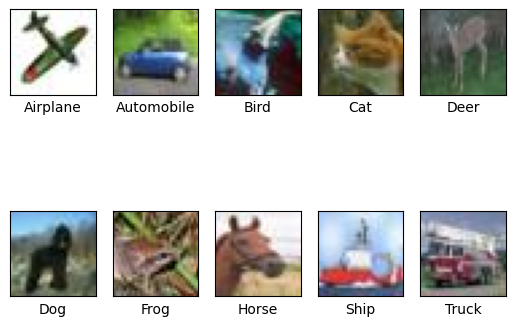

In [4]:
# Show saved images
files = os.listdir(path_images)  
for img in files:
    if os.path.splitext(img)[1] == ext and os.path.splitext(img)[0] in class_names:
        #print(os.path.splitext(img)[0])
        plt.subplot(2,5,class_names.index(os.path.splitext(img)[0])+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mpimg.imread(path_images+img),)
        plt.xlabel(os.path.splitext(img)[0])
plt.show()

### Data preprocessing
Here we normalise the images to be between 0 and 1 which is good practisse in deep learning.

In [5]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Print arrays shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


### Model creation

In [6]:
batch_size = 32
num_classes = len(class_names)
epochs = 1
img_rows, img_cols = x_train.shape[1], x_train.shape[2] # input image dimensions
input_shape = (x_train.shape[1], x_train.shape[2], 1)

In [7]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10)) #The number of classes we have
model.add(Activation('softmax'))

In [8]:
# check model structure and the number of parameters
model.summary()

# Let's train the model using Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                     

In [9]:
# Train model
history = model.fit(x=x_train,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(x_test, y_test))

1563/1563 [==============================] - 31s 20ms/step - loss: 1.9931 - accuracy: 0.2364 - val_loss: 1.6035 - val_accuracy: 0.4049


In [10]:
# Save keras model
path_models = "./Data/models/"
path_keras_model = path_models + "own_cifar10_model.h5"

# Create directory
if not os.path.exists(path_models):
    os.mkdir(path_models)

model.save(path_keras_model)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

  8/313 [..............................] - ETA: 2s - loss: 1.5571 - accuracy: 0.4531

/opt/anaconda3/envs/arm_lab/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 3s 8ms/step - loss: 1.6035 - accuracy: 0.4049
Test loss: 1.60353422164917
Test accuracy: 0.4049000144004822


313/313 - 2s - loss: 1.6035 - accuracy: 0.4049 - 2s/epoch - 8ms/step


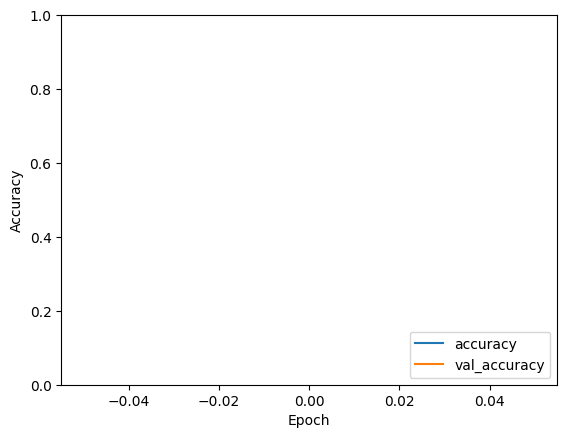

In [11]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

### Validation data creation

In [12]:
path_csv = "./Data/"
path_csv_file = path_csv + "own_cifar10_validation_20image.csv"

# Create directory
if not os.path.exists(path_csv):
    os.mkdir(path_csv)

# Remove old csv file
if os.path.exists(path_csv_file):
    os.remove(path_csv_file)

# Load data from TF Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


# CIFAR10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255

# Print arrays shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
    
# Save csv file that contain pixel's value
num_sample = 50
rx = random.sample(range(0,len(x_test)),num_sample)

for i in range(0,num_sample):
    data = x_test[rx[i]]
    #print(data.shape)
    data = data.flatten()
    output = y_test[rx[i]]
    data=np.append(data,output)
    data = np.reshape(data, (1,data.shape[0]))
    #print(data.shape)
    with open(path_csv_file, 'ab') as f:
        np.savetxt(f, data, delimiter=",")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### Label creation

In [13]:
path_labels = "./Data/labels/"
path_labels_file = path_labels+"own_cifar10_labels.txt"

# Create directory
if not os.path.exists(path_labels):
    os.mkdir(path_labels)
    
# Remove old label file
if os.path.exists(path_labels_file):
    os.remove(path_labels_file)

# Create label file
for i in range(0,len(class_names)):
    with open(path_labels_file, 'a') as f:
        f.write(str(i)+","+class_names[i]+"\n")

## Code credit
Largely contributed
- author = "Pau Danilo Email: danilo.pau@st.com, Carra Alessandro"
- copyright = "Copyright (c) 2018, STMicroelectronics"
- license = "CC BY-NC-SA 3.0 IT - https://creativecommons.org/licenses/by-nc-sa/3.0/"